Shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


Missing values after imputation:
 0
Scaled feature matrix shape: (303, 13)


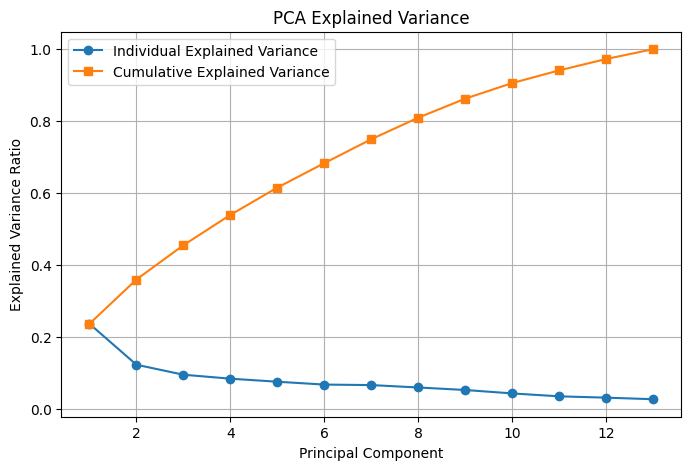

Number of components to retain ≥95% variance: 12
Transformed PCA shape: (303, 12)


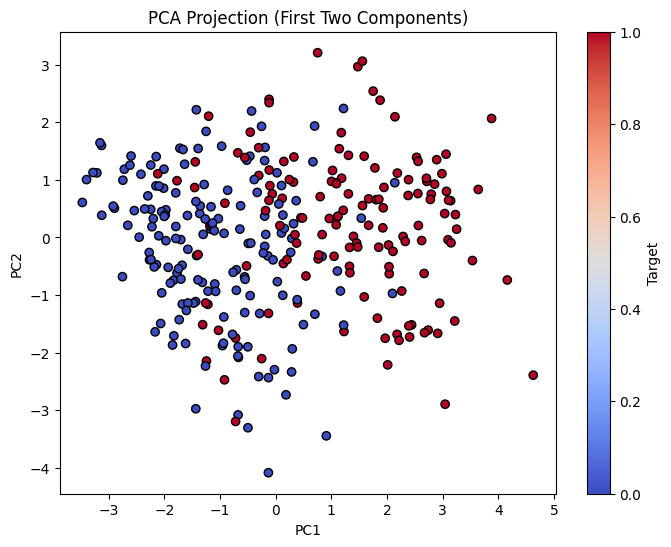

PCA-transformed dataset saved to ../results/pca_heart.csv


In [2]:
# ============================================================
# 02_pca_analysis.ipynb
# Principal Component Analysis on cleaned Heart Disease dataset
# ============================================================

# ---- Cell 1: Imports ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# ---- Cell 2: Load cleaned dataset ----
df = pd.read_csv('../results/cleaned_heart.csv')

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# ---- Cell 3: Separate features and target ----
target_col = 'num'
X = df.drop(columns=[target_col])
y = df[target_col]

# ---- Cell 4: Handle missing values before PCA ----
# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Impute numeric columns with median
if numeric_cols:
    num_imputer = SimpleImputer(strategy='median')
    X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

# Impute categorical columns with most frequent
if categorical_cols:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Check no NaNs remain
print("Missing values after imputation:\n", X.isnull().sum().sum())

# ---- Cell 5: Scale features ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)

# ---- Cell 6: Fit PCA ----
pca = PCA()
pca.fit(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# ---- Cell 7: Variance plots ----
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='s', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# ---- Cell 8: Decide components to retain ----
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain ≥95% variance: {n_components_95}")

# ---- Cell 9: Transform data with optimal components ----
pca_opt = PCA(n_components=n_components_95)
X_pca = pca_opt.fit_transform(X_scaled)

print("Transformed PCA shape:", X_pca.shape)

# ---- Cell 10: 2D PCA scatter plot ----
if n_components_95 >= 2:
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', edgecolor='k')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Projection (First Two Components)')
    plt.colorbar(scatter, label='Target')
    plt.show()
else:
    print("Less than 2 components needed for 95% variance, skipping scatter plot.")

# ---- Cell 11: Save PCA-transformed dataset ----
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components_95)])
pca_df[target_col] = y.values

pca_df.to_csv('../results/pca_heart.csv', index=False)
print("PCA-transformed dataset saved to ../results/pca_heart.csv")
